In [1]:
import torch
import torch_geometric as pyg
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
#iload data
PATH = "/workspaces/masters_project/data/graph_dataset.pt"

In [3]:
#load data
data = torch.load(PATH)
#VISUALISE THE DATA USING NETWORKX
#convert to networkx
G = pyg.utils.to_networkx(data, to_undirected=True)
#draw
plt.figure(figsize=(10, 10))
# nx.draw(G)
# plt.show()

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [4]:
data

Data(x=[512], edge_index=[2, 130816], pos=[512, 2], edge_attr=[130816, 1])

In [4]:
print(512* (512 - 1) /2)
print(nx.is_connected(G))
print(data.edge_attr[0])
print( 512  * 511)

130816.0
True
tensor([0.0165])
261632


# Extract edge distribution

Text(0, 0.5, 'Frequency')

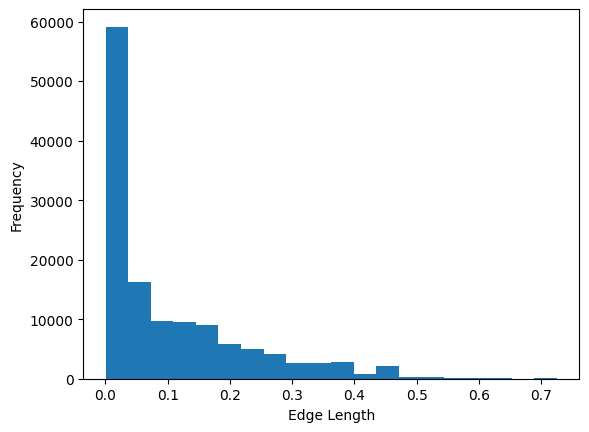

In [5]:
#lets extract all of the edges and see what the overall distribution is
edges_length = data.edge_attr.numpy()
#plot a histogram of the edge lengths
plt.hist(edges_length, bins=20);
plt.xlabel("Edge Length")
plt.ylabel("Frequency")


Now lets write a function that takes in a list of nodes and finds the distribution of edges between them. We will use this to find the distribution of edges between the top 10 nodes.

In [6]:

def extract_edges(graph, node_id):
    """
    Extracts the edges from a graph and returns a list of edges
    """
    #get the edges
    subset = torch.tensor(node_id)
    
    edge_index, edge_attr  = pyg.utils.subgraph(subset=torch.tensor(node_id), edge_index=data.edge_index, edge_attr=data.edge_attr)
    subg_data = data.x[torch.tensor(node_id)]
    subgraph = pyg.data.Data(x = subg_data , edge_index=edge_index, edge_attr=edge_attr)

    return subgraph

In [7]:
#lets take 5 nodes: 2, 5, 10, 11
#generate a list of 50 integers from 0 to 512
interest = np.random.randint(0, 512, 20)
subgraph = extract_edges(graph=data, node_id=interest)
# edge_index, edge_attr  = pyg.utils.subgraph(subset=torch.tensor(interest), edge_index=data.edge_index, edge_attr=data.edge_attr)
# subg_data = data.x[torch.tensor(interest)]

In [8]:
subgraph, data

(Data(x=[20], edge_index=[2, 153], edge_attr=[153, 1]),
 Data(x=[512], edge_index=[2, 130816], pos=[512, 2], edge_attr=[130816, 1]))

/tmp/ipykernel_3104/2901980766.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  [nx.draw_networkx_edges(G,pos=node_pos,edgelist=[key],alpha=np.amin([value*500,1]),width=5) for key,value in cent.items()] #loop through edges and draw them


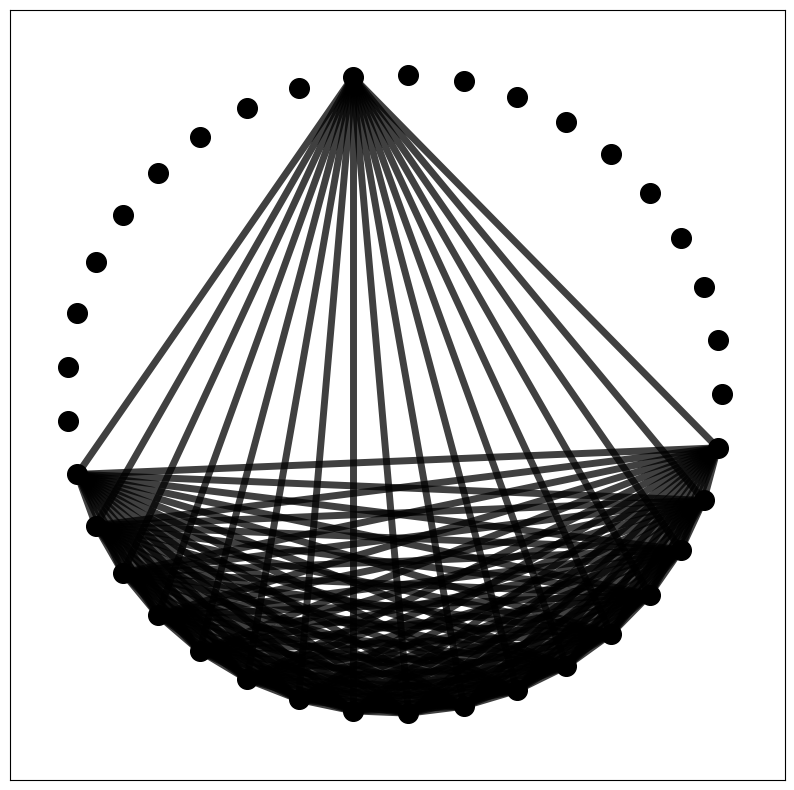

In [9]:
#plot the subgraph and then histogram of edges
#convert to networkx
G = pyg.utils.to_networkx(subgraph, to_undirected=True)
#draw
options = {
    'node_color':'black',
    'node_size':200
}

cent=nx.edge_betweenness_centrality(G)
node_pos=nx.circular_layout(G) #Any layout will work here, including nx.spring_layout(G)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G,pos=node_pos,**options)#draw nodes
[nx.draw_networkx_edges(G,pos=node_pos,edgelist=[key],alpha=np.amin([value*500,1]),width=5) for key,value in cent.items()] #loop through edges and draw them

plt.show()


Text(0.5, 0, 'Edge Length')

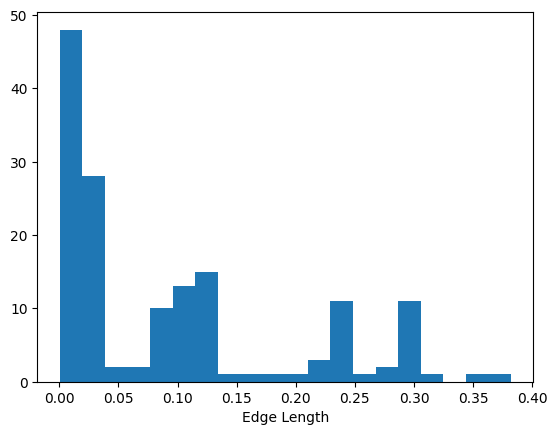

In [10]:
#plot the histogram of the edge lengths
edges_length = subgraph.edge_attr.numpy()
#plot a histogram of the edge lengths
plt.hist(edges_length, bins=20);
plt.xlabel("Edge Length")

# Compare length distributions

In [11]:
interest_1 = np.random.randint(0, 512, 500)
subgraph_1 = extract_edges(graph=data, node_id=interest_1)
#take the interest to be every node that isnt in interest_1
interest_2 = np.setdiff1d(np.arange(0, 512), interest_1)
#interest_2 = np.random.randint(0, 512, 500)
subgraph_2 = extract_edges(graph=data, node_id=interest_2)
edges_length_1 = subgraph_1.edge_attr.numpy()
edges_length_2 = subgraph_2.edge_attr.numpy()


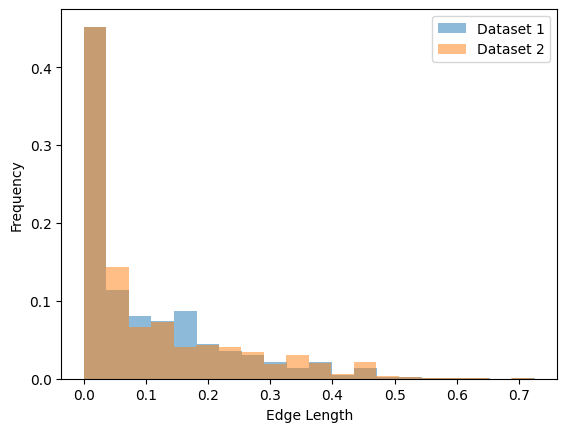

In [12]:
hist1, bins1 = np.histogram(edges_length_1, bins=20, density=True)
hist2, bins2 = np.histogram(edges_length_2, bins=20, density=True)

# Normalize the histograms
hist1 /= hist1.sum()
hist2 /= hist2.sum()

# Calculate the bin centers
bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
bin_centers2 = (bins2[:-1] + bins2[1:]) / 2

# Plot the normalized histograms
plt.bar(bin_centers1, hist1, width=(bin_centers1[1] - bin_centers1[0]), alpha=0.5, label='Dataset 1')
plt.bar(bin_centers2, hist2, width=(bin_centers2[1] - bin_centers2[0]), alpha=0.5, label='Dataset 2')
plt.xlabel("Edge Length")
plt.ylabel("Frequency")

plt.legend(loc='upper right')

# 

In [13]:
edges_length_1.shape, edges_length_2.shape

((48516, 1), (19900, 1))

In [14]:
subgraph_1, subgraph_2

(Data(x=[500], edge_index=[2, 48516], edge_attr=[48516, 1]),
 Data(x=[200], edge_index=[2, 19900], edge_attr=[19900, 1]))

In [15]:
#Compput the  KL divergence between the two distributions
from scipy.stats import entropy
#get the highest of the two distributions

kl_div = entropy(bin_centers1, bin_centers2)
print(kl_div)


4.084245e-08


# Extension to N subgraphs

The aim now is to extend this to N subgraphs. To do this, we will first allocate each node to be one of N graphs.

0.2965854864182227


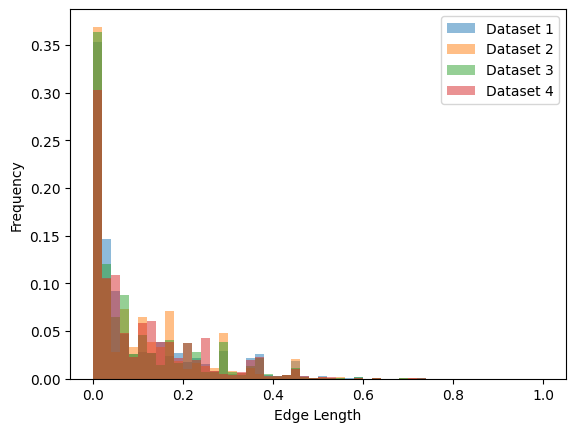

In [16]:
def subgraph_extractor(graph, num_subg):
    """
    """
    subgraphs = []
    #take the number of nodes of the graph
    num_nodes = graph.x.shape[0]
    #should be 0 and num_nodes! to make sure we get 512 nodes
    array = np.arange(0, num_nodes)
    np.random.shuffle(array)
    partitions = np.array_split(array, num_subg)
    
    #print number of nodes in each subgraph

    num_x = 0
    for i in range(0, num_subg):
        subgraph = extract_edges(graph=graph, node_id=partitions[i])
        subgraphs.append(subgraph)
    return subgraphs
    #now allocate a random number of nodes to each subgraph
    #take a random number of nodes from 1 to num_nodes

def get_edge_distributions(graph, num_nodes, NBINS=50):
    subgraphs = subgraph_extractor(graph, num_nodes)
    edge_hist = []
    hist_dict = []
    i = 1
    bin_centers_dict = []
    for subgraph in subgraphs:
        edges_length = subgraph.edge_attr.numpy()
        hist, bins = np.histogram(edges_length, bins=NBINS, density=True,
                                  range=(0, 1))
        hist /= hist.sum()
        edge_hist.append(hist)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        plt.bar(bin_centers, hist, width=(bin_centers[1] - bin_centers[0]),
                 alpha=0.5, label=f'Dataset {i}')

        i += 1
        bin_centers_dict.append(bin_centers)
        hist_dict.append(hist)
        #plot a histogram of the edge lengths
    plt.xlabel("Edge Length")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    #plt.show()
    #I want to compute the KL divergence between each of the distributions
    #for each of the distributions compute the KL divergence
    kl_div = []
    for i in range(0, len(edge_hist)):
        for j in range(0, len(edge_hist)):
            kl_div.append(entropy(edge_hist[i], edge_hist[j]))
    #compute the sum of the KL divergences
    kl_div = np.array(kl_div)
    #sum the KL divergences
    #if kl_div is infinty then set it to 0
    kl_div[kl_div == np.inf] = 0
    kl_div = np.sum(kl_div)
    return kl_div, bin_centers_dict, hist_dict
print(get_edge_distributions(data, 4)[0])

1.0393152475480636
0.42389360753298283
0.0939139031852951


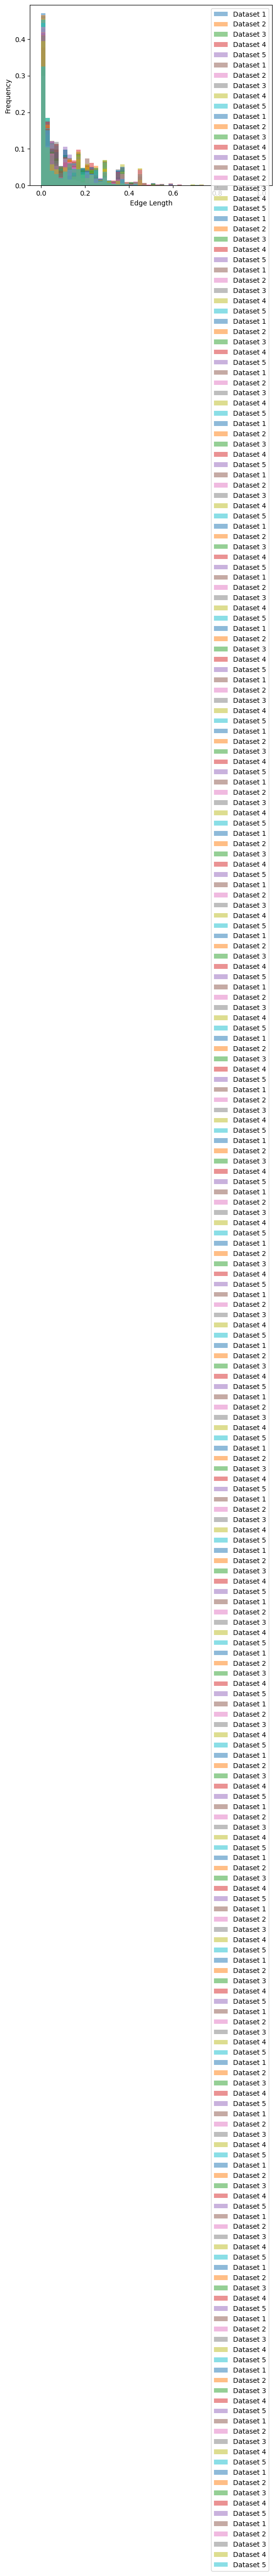

In [17]:

kl_div_best = 100000
best_centers, best_hist = None, None
for i in range(0, 50):
    
    kl_div, bin_centers_dict, hist_dict = get_edge_distributions(data, 5)
    if kl_div < kl_div_best:
        kl_div_best = kl_div
        best_centers = bin_centers_dict
        best_hist = hist_dict
        print(kl_div_best)


0.0939139031852951


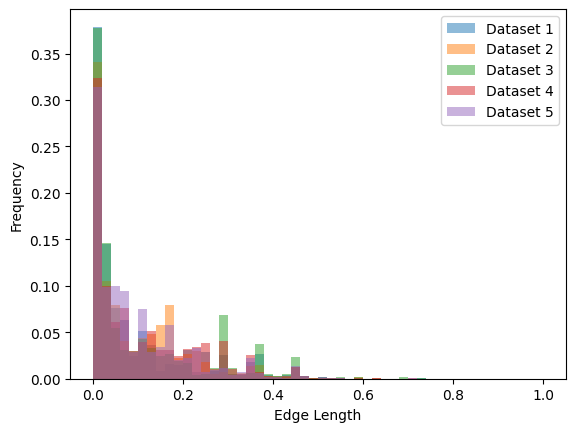

In [18]:

#plot the best centers
print(kl_div_best)
for i in range(0, len(best_centers)):
    plt.bar(best_centers[i], best_hist[i], width=(best_centers[i][1] - best_centers[i][0]),
                 alpha=0.5, label=f'Dataset {i + 1}')
plt.xlabel("Edge Length")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

# New loss function (fourier transform)

In [19]:
#find all elemnets in interst_2 that are in interest_1
#find the intersection of the two arrays
#find the union of the two arrays

intersection = np.intersect1d(interest_1, interest_2)

union = np.union1d(interest_1, interest_2)
union.shape

(512,)

In [20]:
#why is interst_2 not the interst_1


In [21]:
tot = np.arange(1, 513, 1)
#take all elements of tot not in interest_1
not_interest_1 = np.setdiff1d(tot, interest_1, assume_unique=True)
not_interest_2 = np.setdiff1d(tot, interest_2, assume_unique=True)
not_interest_1.shape

(201,)

In [22]:
interest_1 = np.random.randint(0, 512, 256)
#let interst be number from 0 to 256
interest_1 = np.arange(0, 256, 1)

subgraph_1 = extract_edges(graph=data, node_id=interest_1)
#take the interest to be every node that isnt in interest_1
interest_2 = np.setdiff1d(np.arange(0, 512), interest_1)
#interest_2 = np.random.randint(0, 512, 500)
subgraph_2 = extract_edges(graph=data, node_id=interest_2)
edges_length_1 = subgraph_1.edge_attr.numpy()
edges_length_2 = subgraph_2.edge_attr.numpy()

print(edges_length_1.shape, edges_length_2.shape)
print(interest_1.shape, interest_2.shape)

(32640, 1) (32640, 1)
(256,) (256,)


In [23]:
#take the fft of the two distributions using torch
import torch
#force edge_length_1 to be diffrentiable
edges_length_1 = torch.tensor(edges_length_1, requires_grad=True)
edges_length_2 = torch.tensor(edges_length_2, requires_grad=True)

fft1 = torch.fft.fft(torch.tensor(edges_length_1), )
fft2 = torch.fft.fft(torch.tensor(edges_length_2), )


#compute the sum of the real and imaginary parts
fft1_sorted = torch.sort(fft1.real)
fft2_sorted = torch.sort(fft2.real)
#compute the mse between the two
mse = torch.nn.MSELoss()
loss = mse(fft1_sorted, fft2_sorted)
loss.backward()

/tmp/ipykernel_3104/927917418.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fft1 = torch.fft.fft(torch.tensor(edges_length_1), )
/tmp/ipykernel_3104/927917418.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fft2 = torch.fft.fft(torch.tensor(edges_length_2), )


AttributeError: 'torch.return_types.sort' object has no attribute 'size'

ValueError: x must have 2 or fewer dimensions

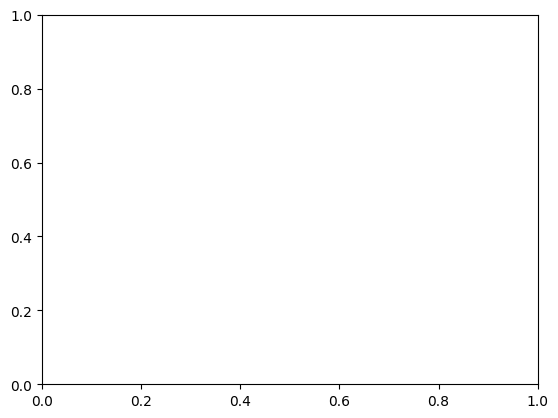

In [ ]:
#plot the fft1, fft2
#plt.plot(fft1_sorted, label="fft1")
#plot the histogram of the edge lengths
#plt.plot(fft2_sorted, label="fft2")
plt.hist(fft1_sorted, bins=20, label="fft1");
plt.hist(fft2_sorted, bins=20, label="fft2");

In [ ]:
#get a histogram of fft1
#use numpy to bin the data
#use torch to compute the fft

bin_1 = np.histogram(fft1_sorted, bins=20)
bin_2 = np.histogram(fft2_sorted, bins=20)


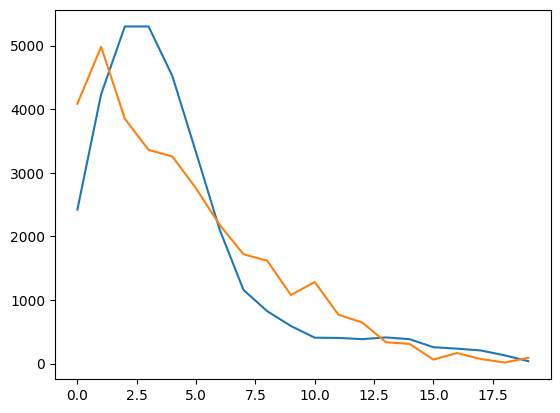

In [ ]:
#plot the bins
plt.plot(bin_1[0], label="bin1")
plt.plot(bin_2[0], label="bin2")

In [ ]:
#take the fft of the two distributions using torch
import torch
mse = torch.nn.MSELoss()

edges_length_1 = torch.tensor(edges_length_1, requires_grad=True)
edges_length_2 = torch.tensor(edges_length_2, requires_grad=True)
#check that edge_lenght_1 and edge_length_2 are differentiable
edges_length_1.shape, edges_length_2.shape


/tmp/ipykernel_1610/1742888802.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_length_1 = torch.tensor(edges_length_1, requires_grad=True)
/tmp/ipykernel_1610/1742888802.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_length_2 = torch.tensor(edges_length_2, requires_grad=True)


(torch.Size([32640, 1]), torch.Size([32640, 1]))

In [ ]:
edges_length_1._backward_hooks
fft1 = torch.fft.fft(torch.tensor(edges_length_1))



/tmp/ipykernel_1610/3255590993.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fft1 = torch.fft.fft(torch.tensor(edges_length_1))


In [ ]:

#force edge_length_1 to be diffrentiable
edges_length_1 = torch.tensor(edges_length_1, requires_grad=True)
edges_length_2 = torch.tensor(edges_length_2, requires_grad=True)

fft1 = torch.fft.fft(torch.tensor(edges_length_1), )
fft2 = torch.fft.fft(torch.tensor(edges_length_2), )


#compute the sum of the real and imaginary parts
fft1_sorted = torch.sort(fft1.real)
fft2_sorted = torch.sort(fft2.real)
#compute the mse between the two
loss = mse(fft1_sorted, fft2_sorted)
loss.backward()

/tmp/ipykernel_1610/2740003473.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_length_1 = torch.tensor(edges_length_1, requires_grad=True)
/tmp/ipykernel_1610/2740003473.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_length_2 = torch.tensor(edges_length_2, requires_grad=True)
/tmp/ipykernel_1610/2740003473.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fft1 = torch.fft.fft(torch.tensor(edges_length_1), )
/tmp/ipykernel_1610/2740003473.py:6: UserWarning: To copy construct from a tensor, it is recommended to use so

AttributeError: 'torch.return_types.sort' object has no attribute 'size'

In [23]:
x = torch.randn(512, 1)
x2 = torch.randn(512, 1)


In [24]:
#write a sequantial model that has 1 input and 500 outputs
#the input is some random matrix
#the output is the fft of the random matrix

#write a sequantial model that has 1 input and 500 outputs
model = torch.nn.Sequential(
    torch.nn.Linear(1, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 500),
)

y = model(x)
y_1 = model(x2)
z = torch.fft.fft(y)
z = torch.abs(z)
z1 = torch.fft.fft(z).abs()
z1 = torch.sort(z1)[0]
z = torch.sort(z)[0]

loss = mse(z, z1)
loss.backward()
loss

tensor(732.0408, grad_fn=<MseLossBackward0>)

In [153]:
z.shape

torch.Size([512, 500])

# GNN Attempt

In [25]:
import torch_geometric as pyg
import torch

In [26]:
graph = data
data
#write a simple GNN that outputs the fft of the graph edges
#the input is the graph

class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = pyg.nn.GCNConv(1, 500)
        self.conv2 = pyg.nn.GCNConv(500, 500,)
        self.conv3 = pyg.nn.GCNConv(500, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.unsqueeze(1)
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return x, data

gnn_model = GNNModel()


In [27]:
graph

Data(x=[512], edge_index=[2, 130816], pos=[512, 2], edge_attr=[130816, 1])

In [28]:
output, data_2 = gnn_model(graph)
output.shape, data_2


(torch.Size([512, 1]),
 Data(x=[512], edge_index=[2, 130816], pos=[512, 2], edge_attr=[130816, 1]))

In [29]:
# y = model(x)
# y_1 = model(x2)

z = torch.fft.fft(output.abs())

z = torch.abs(z)
z1 = torch.fft.fft(z).abs()
z1 = torch.sort(z1)[0]
z = torch.sort(z)[0]

loss = mse(z, z1)
loss.backward()
loss

tensor(0., grad_fn=<MseLossBackward0>)

In [30]:
output.shape

torch.Size([512, 1])

In [31]:
copy_x = data.x.clone()

In [32]:
#So we have x, lets apply softmax to x and then check all the edges associated with x

In [36]:
copy_x = torch.nn.functional.softmax(copy_x, dim=0)
copy_x.shape

torch.Size([512])